-- Get indicator to analyze

  -- Top/Bottom method
  
  -- Cosine Vector method 
  
-- Get df_indicators

-- Return list_indicator_to_analyze

	-- for each indicator.
    
	 -- calcule features.
	 

In [1]:
# Load libraries
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spstats
import xgboost as xgb

from xgboost import XGBClassifier
from rfpimp import permutation_importances
from scipy.spatial import distance 
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm



pd.set_option("display.width"    , 1000)
pd.set_option("display.max_rows" , 1500)

pd.options.display.max_colwidth = 100

# Static info
REMOVE_COUNTRIES_CLUSTERS ="""
   ( 
      CountryCode != 'WLD' AND     CountryCode != 'LMY' AND     CountryCode != 'MIC' AND     CountryCode != 'LMC' AND     CountryCode != 'UMC' AND     CountryCode != 'EAS' AND     CountryCode != 'EAP' AND     CountryCode != 'SAS' AND     CountryCode != 'HIC' AND     CountryCode != 'OED' AND     CountryCode != 'OEC' AND     CountryCode != 'SSF' AND     CountryCode != 'SSA' AND     CountryCode != 'LDC' AND     CountryCode != 'ECS' AND     CountryCode != 'LCN' AND     CountryCode != 'LIC' AND     CountryCode != 'LAC' AND     CountryCode != 'EUU' AND     CountryCode != 'FCS' AND     CountryCode != 'MEA' AND     CountryCode != 'ARB' AND     CountryCode != 'MNA' AND     CountryCode != 'NAC' AND     CountryCode != 'EMU' AND     CountryCode != 'NOC'   AND     CountryCode != 'ECA' AND     CountryCode != 'HPC' 
    )
"""


ARRAY_INDICATORS=[       'Access to electricity (% of population)',
    'Access to non-solid fuel (% of population)',
    'Adjusted net enrolment rate, primary, both sexes (%)',
    'Adjusted net national income (annual % growth)',
    'Adjusted net national income (constant 2005 US$)',
    'Adjusted net national income per capita (annual % growth)',
    'Adjusted net national income per capita (constant 2005 US$)',
    'Adjusted net savings, excluding particulate emission damage (% of GNI)',
    'Adjusted net savings, including particulate emission damage (% of GNI)',
    'Adjusted savings: carbon dioxide damage (% of GNI)',
    'Adjusted savings: consumption of fixed capital (% of GNI)',
    'Adjusted savings: education expenditure (% of GNI)',
    'Adjusted savings: energy depletion (% of GNI)',
    'Adjusted savings: gross savings (% of GNI)',
    'Adjusted savings: mineral depletion (% of GNI)',
    'Adjusted savings: natural resources depletion (% of GNI)',
    'Adjusted savings: net forest depletion (% of GNI)',
    'Adjusted savings: net national savings (% of GNI)',
    'Adjusted savings: particulate emission damage (% of GNI)',
    'Adolescent fertility rate (births per 1,000 women ages 15-19)',
    'Adult literacy rate, population 15+ years, both sexes (%)',
    'Age dependency ratio (% of working-age population)',
    'Age dependency ratio, old (% of working-age population)',
    'Age dependency ratio, young (% of working-age population)',
    'Agricultural irrigated land (% of total agricultural land)',
    'Agricultural land (% of land area)',
    'Agricultural machinery, tractors per 100 sq. km of arable land',
    'Agricultural raw materials exports (% of merchandise exports)',
    'Agricultural raw materials imports (% of merchandise imports)',
    'Agriculture value added per worker (constant 2005 US$)',
    'Agriculture, value added (% of GDP)',
    'Agriculture, value added (annual % growth)',
    'Agriculture, value added (constant 2005 US$)',
    'Alternative and nuclear energy (% of total energy use)',
    'Annualized average growth rate in per capita real survey mean consumption or income, bottom 40% of population (%)',
    'Annualized average growth rate in per capita real survey mean consumption or income, total population (%)',
    'Arable land (% of land area)',
    'Armed forces personnel, total',
    'Arms exports (SIPRI trend indicator values)',
    'Arms imports (SIPRI trend indicator values)',
    'Automated teller machines (ATMs) (per 100,000 adults)',
    'Average precipitation in depth (mm per year)',
    'Average time to clear exports through customs (days)',
    'Bank capital to assets ratio (%)',
    'Bank nonperforming loans to total gross loans (%)',
    'Battle-related deaths (number of people)',
    'Binding coverage, all products (%)',
    'Binding coverage, manufactured products (%)',
    'Binding coverage, primary products (%)',
    'Bound rate, simple mean, all products (%)',
    'Bound rate, simple mean, manufactured products (%)',
    'Bound rate, simple mean, primary products (%)',
    'Burden of customs procedure, WEF (1=extremely inefficient to 7=extremely efficient)',
    'Business extent of disclosure index (0=less disclosure to 10=more disclosure)',
    'Cash surplus/deficit (% of GDP)',
    'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
    'Cause of death, by injury (% of total)',
    'Cause of death, by non-communicable diseases (% of total)',
    'Central government debt, total (% of GDP)',
    'Cereal production (metric tons)', 'Cereal yield (kg per hectare)',
    'Chemicals (% of value added in manufacturing)',
    'Coal rents (% of GDP)',
    'Combustible renewables and waste (% of total energy)',
    'Commercial bank branches (per 100,000 adults)',
    'Communications, computer, etc. (% of service exports, BoP)',
    'Communications, computer, etc. (% of service imports, BoP)',
    'Compensation of employees (% of expense)',
    'Computer, communications and other services (% of commercial service exports)',
    'Computer, communications and other services (% of commercial service imports)',
    'Consumer price index (2010 = 100)',
    'Container port traffic (TEU: 20 foot equivalent units)',
    'Contraceptive prevalence (% of women ages 15-49)',
    'Contributing family workers, total (% of total employed)',
    'Cost of business start-up procedures (% of GNI per capita)',
    'Cost to export (US$ per container)',
    'Cost to import (US$ per container)',
    'Crop production index (2004-2006 = 100)',
    'Current account balance (% of GDP)',
    'Current education expenditure, primary (% of total expenditure in primary public institutions)',
    'Current education expenditure, secondary (% of total expenditure in secondary public institutions)',
    'Current education expenditure, tertiary (% of total expenditure in tertiary public institutions)',
    'Current education expenditure, total (% of total expenditure in public institutions)',
    'Customs and other import duties (% of tax revenue)',
    'Death rate, crude (per 1,000 people)',
    'Delay in obtaining an electrical connection (days)',
    'Deposit interest rate (%)',
    'Depth of credit information index (0=low to 8=high)',
    'Diabetes prevalence (% of population ages 20 to 79)',
    'Distance to frontier score (0=lowest performance to 100=frontier)',
    'Documents to export (number)', 'Documents to import (number)',
    'Droughts, floods, extreme temperatures (% of population, average 1990-2009)',
    'Ease of doing business index (1=most business-friendly regulations)',
    'Electric power consumption (kWh per capita)',
    'Electric power transmission and distribution losses (% of output)',
    'Electricity production from coal sources (% of total)',
    'Electricity production from hydroelectric sources (% of total)',
    'Electricity production from natural gas sources (% of total)',
    'Electricity production from nuclear sources (% of total)',
    'Electricity production from oil sources (% of total)',
    'Electricity production from renewable sources, excluding hydroelectric (% of total)',
    'Emigration rate of tertiary educated (% of total tertiary educated population)',
    'Employers, total (% of employment)',
    'Employment in agriculture (% of total employment)',
    'Employment in industry (% of total employment)',
    'Employment in services (% of total employment)',
    'Employment to population ratio, 15+, total (%) (modeled ILO estimate)',
    'Employment to population ratio, ages 15-24, total (%) (modeled ILO estimate)',
    'Energy imports, net (% of energy use)',
    'Energy intensity level of primary energy (MJ/$2011 PPP GDP)',
    'Energy use (kg of oil equivalent per capita)',
    'Energy use (kg of oil equivalent) per $1,000 GDP (constant 2011 PPP)',
    'Enrolment in primary education, both sexes (number)',
    'Enrolment in secondary education, both sexes (number)',
    'Enrolment in secondary general, both sexes (number)',
    'Enrolment in secondary vocational, both sexes (number)',
    'Expenditure on education as % of total government expenditure (%)',
    'Expenditure on primary as % of government expenditure on education (%)',
    'Expenditure on secondary as % of government expenditure on education (%)',
    'Expenditure on tertiary as % of government expenditure on education (%)',
    'Export value index (2000 = 100)',
    'Export volume index (2000 = 100)',
    'Exports of goods and services (% of GDP)',
    'Exports of goods and services (annual % growth)',
    'Exports of goods and services (constant 2005 US$)',
    'External balance on goods and services (% of GDP)',
    'External resources for health (% of total expenditure on health)',
    'Fertility rate, total (births per woman)',
    'Fertilizer consumption (% of fertilizer production)',
    'Fertilizer consumption (kilograms per hectare of arable land)',
    'Final consumption expenditure (constant 2005 US$)',
    'Final consumption expenditure, etc. (% of GDP)',
    'Final consumption expenditure, etc. (annual % growth)',
    'Final consumption expenditure, etc. (constant 2005 US$)',
    'Firms expected to give gifts in meetings with tax officials (% of firms)',
    'Firms offering formal training (% of firms)',
    'Firms that do not report all sales for tax purposes (% of firms)',
    'Firms using banks to finance investment (% of firms)',
    'Firms using banks to finance working capital (% of firms)',
    'Fixed broadband subscriptions (per 100 people)',
    'Fixed telephone subscriptions (per 100 people)',
    'Food exports (% of merchandise exports)',
    'Food imports (% of merchandise imports)',
    'Food production index (2004-2006 = 100)',
    'Food, beverages and tobacco (% of value added in manufacturing)',
    'Foreign direct investment, net inflows (% of GDP)',
    'Foreign direct investment, net outflows (% of GDP)',
    'Forest area (% of land area)', 'Forest area (sq. km)',
    'Forest rents (% of GDP)',
    'Fossil fuel energy consumption (% of total)',
    'Fuel exports (% of merchandise exports)',
    'GDP deflator (base year varies by country)',
    'GDP growth (annual %)',
    'GDP per capita (constant 2005 US$)',
    'GDP per person employed (constant 1990 PPP $)',
    'GDP per unit of energy use (constant 2011 PPP $ per kg of oil equivalent)',
    'GDP, PPP (constant 2011 international $)',
    'GEF benefits index for biodiversity (0 = no biodiversity potential to 100 = maximum)',
    'GINI index (World Bank estimate)', 'GNI (constant 2005 US$)',
    'GNI growth (annual %)', 'GNI per capita (constant 2005 US$)',
    'GNI per capita growth (annual %)',
    'GNI per capita, PPP (constant 2011 international $)',
    'General government final consumption expenditure (% of GDP)',
    'General government final consumption expenditure (annual % growth)',
    'General government final consumption expenditure (constant 2005 US$)',
    'Goods and services expense (% of expense)',
    'Government expenditure on education as % of GDP (%)',
    'Government expenditure per primary student as % of GDP per capita (%)',
    'Government expenditure per secondary student as % of GDP per capita (%)',
    'Government expenditure per tertiary student as % of GDP per capita (%)',
    'Grants and other revenue (% of revenue)',
    'Gross capital formation (% of GDP)',
    'Gross capital formation (annual % growth)',
    'Gross capital formation (constant 2005 US$)',
    'Gross domestic income (constant 2005 US$)',
    'Gross domestic savings (% of GDP)',
    'Gross enrolment ratio, pre-primary, both sexes (%)',
    'Gross enrolment ratio, primary and secondary, gender parity index (GPI)',
    'Gross enrolment ratio, primary, both sexes (%)',
    'Gross enrolment ratio, primary, gender parity index (GPI)',
    'Gross enrolment ratio, secondary, both sexes (%)',
    'Gross enrolment ratio, tertiary, both sexes (%)',
    'Gross enrolment ratio, tertiary, gender parity index (GPI)',
    'Gross fixed capital formation (% of GDP)',
    'Gross fixed capital formation (annual % growth)',
    'Gross fixed capital formation (constant 2005 US$)',
    'Gross intake ratio to Grade 1 of primary education, both sexes (%)',
    'Gross national expenditure (% of GDP)',
    'Gross national expenditure (constant 2005 US$)',
    'Gross national expenditure deflator (base year varies by country)',
    'Gross savings (% of GDP)', 'Gross savings (% of GNI)',
    'Gross value added at factor cost (constant 2005 US$)',
    'Health expenditure per capita, PPP (constant 2011 international $)',
    'Health expenditure, private (% of GDP)',
    'Health expenditure, public (% of GDP)',
    'Health expenditure, total (% of GDP)',
    'High-technology exports (% of manufactured exports)',
    'Hospital beds (per 1,000 people)',
    'Household final consumption expenditure (annual % growth)',
    'Household final consumption expenditure (constant 2005 US$)',
    'Household final consumption expenditure per capita (constant 2005 US$)',
    'Household final consumption expenditure per capita growth (annual %)',
    'Household final consumption expenditure, PPP (constant 2011 international $)',
    'Household final consumption expenditure, PPP (current international $)',
    'Household final consumption expenditure, etc. (% of GDP)',
    'Household final consumption expenditure, etc. (annual % growth)',
    'Household final consumption expenditure, etc. (constant 2005 US$)',
    'ICT goods exports (% of total goods exports)',
    'ICT goods imports (% total goods imports)',
    'ICT service exports (% of service exports, BoP)',
    'Import value index (2000 = 100)',
    'Imports of goods and services (% of GDP)',
    'Improved sanitation facilities (% of population with access)',
    'Improved sanitation facilities, rural (% of rural population with access)',
    'Improved sanitation facilities, urban (% of urban population with access)',
    'Income share held by fourth 20%',
    'Income share held by highest 10%',
    'Income share held by highest 20%',
    'Income share held by lowest 10%',
    'Income share held by lowest 20%',
    'Income share held by second 20%',
    'Income share held by third 20%',
    'Industry, value added (% of GDP)',
    'Industry, value added (annual % growth)',
    'Industry, value added (constant 2005 US$)',
    'Inflation, GDP deflator (annual %)',
    'Inflation, consumer prices (annual %)',
    'Informal payments to public officials (% of firms)',
    'Insurance and financial services (% of commercial service exports)',
    'Insurance and financial services (% of commercial service imports)',
    'Insurance and financial services (% of service exports, BoP)',
    'Insurance and financial services (% of service imports, BoP)',
    'Intentional homicides (per 100,000 people)',
    'Interest payments (% of expense)',
    'Interest payments (% of revenue)',
    'Interest rate spread (lending rate minus deposit rate, %)',
    'International migrant stock (% of population)',
    'International migrant stock, total',
    'International tourism, expenditures (% of total imports)',
    'International tourism, number of arrivals',
    'International tourism, number of departures',
    'International tourism, receipts (% of total exports)',
    'Internationally-recognized quality certification (% of firms)',
    'Internet users (per 100 people)',
    'Labor force participation rate for ages 15-24, total (%) (modeled ILO estimate)',
    'Labor force participation rate for ages 15-24, total (%) (national estimate)',
    'Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)',
    'Labor force participation rate, total (% of total population ages 15+) (national estimate)',
    'Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)',
    'Labor force with primary education (% of total)',
    'Labor force with secondary education (% of total)',
    'Labor force with tertiary education (% of total)',
    'Labor tax and contributions (% of commercial profits)',
    'Lead time to export, median case (days)',
    'Lead time to import, median case (days)',
    'Lending interest rate (%)',
    'Life expectancy at birth, total (years)',
    'Lifetime risk of maternal death (%)',
    'Lifetime risk of maternal death (1 in: rate varies by country)',
    'Liner shipping connectivity index (maximum value in 2004 = 100)',
    'Listed domestic companies, total',
    'Livestock production index (2004-2006 = 100)',
    'Logistics performance index: Overall (1=low to 5=high)',
    'Long-term unemployment (% of total unemployment)',
    'Losses due to theft, robbery, vandalism, and arson (% sales)',
    'Low-birthweight babies (% of births)',
    'Lower secondary completion rate, both sexes (%)',
    'Machinery and transport equipment (% of value added in manufacturing)',
    'Manufactures exports (% of merchandise exports)',
    'Manufactures imports (% of merchandise imports)',
    'Manufacturing, value added (% of GDP)',
    'Manufacturing, value added (annual % growth)',
    'Manufacturing, value added (constant 2005 US$)',
    'Marine protected areas (% of territorial waters)',
    'Market capitalization of listed domestic companies (% of GDP)',
    'Merchandise trade (% of GDP)',
    'Military expenditure (% of GDP)',
    'Military expenditure (% of central government expenditure)',
    'Mobile cellular subscriptions (per 100 people)',
    'Mortality rate, infant (per 1,000 live births)',
    'Mortality rate, neonatal (per 1,000 live births)',
    'Mortality rate, under-5 (per 1,000)',
    'Natural gas rents (% of GDP)',
    'Net barter terms of trade index (2000 = 100)',
    'Net enrolment rate, primary, both sexes (%)',
    'Net enrolment rate, secondary, both sexes (%)',
    'Net incurrence of liabilities, domestic (% of GDP)',
    'Net incurrence of liabilities, foreign (% of GDP)',
    'Net intake rate to Grade 1 of primary education, both sexes (%)',
    'New business density (new registrations per 1,000 people ages 15-64)',
    'Nurses and midwives (per 1,000 people)',
    'Official entrance age to lower secondary education (years)',
    'Official entrance age to primary education (years)',
    'Oil rents (% of GDP)',
    'Ores and metals exports (% of merchandise exports)',
    'Ores and metals imports (% of merchandise imports)',
    'Other expense (% of expense)',
    'Other manufacturing (% of value added in manufacturing)',
    'Other taxes payable by businesses (% of commercial profits)',
    'Out-of-pocket health expenditure (% of private expenditure on health)',
    'Out-of-pocket health expenditure (% of total expenditure on health)',
    'Out-of-school children of primary school age, both sexes (number)',
    'Part time employment, total (% of total employment)',
    'Percentage of enrolment in primary education in private institutions (%)',
    'Percentage of enrolment in secondary education in private institutions (%)',
    'Percentage of repeaters in primary education, all grades, both sexes (%)',
    'Percentage of repeaters in secondary general education, all grades, both sexes (%)',
    'Permanent cropland (% of land area)',
    'Personal remittances, received (% of GDP)',
    'Point-of-sale terminals (per 100,000 adults)',
    'Population ages 65 and above (% of total)',
    'Population density (people per sq. km of land area)',
    'Population growth (annual %)', 'Population in largest city',
    'Population in the largest city (% of urban population)',
    'Population in urban agglomerations of more than 1 million (% of total population)',
    'Population living in areas where elevation is below 5 meters (% of total population)',
    'Population, ages 0-14 (% of total)',
    'Population, ages 15-64 (% of total)',
    'Price level ratio of PPP conversion factor (GDP) to market exchange rate',
    'Primary completion rate, both sexes (%)',
    'Primary to secondary general education transition rate, both sexes (%)',
    'Private credit bureau coverage (% of adults)',
    'Procedures to build a warehouse (number)',
    'Procedures to register property (number)',
    'Profit tax (% of commercial profits)',
    'Proportion of seats held by women in national parliaments (%)',
    'Public credit registry coverage (% of adults)',
    'Pump price for diesel fuel (US$ per liter)',
    'Pump price for gasoline (US$ per liter)',
    'Pupil-teacher ratio in primary education (headcount basis)',
    'Pupil-teacher ratio in secondary education (headcount basis)',
    'Quality of port infrastructure, WEF (1=extremely underdeveloped to 7=well developed and efficient by international standards)',
    'Rail lines (total route-km)',
    'Railways, goods transported (million ton-km)',
    'Railways, passengers carried (million passenger-km)',
    'Real effective exchange rate index (2010 = 100)',
    'Real interest rate (%)',
    'Renewable electricity output (% of total electricity output)',
    'Renewable energy consumption (% of total final energy consumption)',
    'Renewable internal freshwater resources per capita (cubic meters)',
    'Renewable internal freshwater resources, total (billion cubic meters)',
    'Research and development expenditure (% of GDP)',
    'Researchers in R&D (per million people)',
    'Revenue, excluding grants (% of GDP)',
    'Risk premium on lending (lending rate minus treasury bill rate, %)',
    'Rural population (% of total population)',
    'Rural population growth (annual %)',
    'S&P Global Equity Indices (annual % change)',
    'Scientific and technical journal articles',
    'Self-employed, total (% of total employed)',
    'Services, etc., value added (% of GDP)',
    'Services, etc., value added (annual % growth)',
    'Services, etc., value added (constant 2005 US$)',
    'Share of tariff lines with international peaks, all products (%)',
    'Share of tariff lines with international peaks, manufactured products (%)',
    'Share of tariff lines with international peaks, primary products (%)',
    'Share of tariff lines with specific rates, all products (%)',
    'Share of tariff lines with specific rates, manufactured products (%)',
    'Share of tariff lines with specific rates, primary products (%)',
    'Share of women in wage employment in the nonagricultural sector (% of total nonagricultural employment)',
    'Share of youth not in education, employment, or training, total (% of youth population)',
    'Social contributions (% of revenue)',
    'Start-up procedures to register a business (number)',
    'Stocks traded, total value (% of GDP)',
    'Stocks traded, turnover ratio of domestic shares (%)',
    'Strength of legal rights index (0=weak to 12=strong)',
    'Subsidies and other transfers (% of expense)',
    'Survey mean consumption or income per capita, bottom 40% of population (2011 PPP $ per day)',
    'Survey mean consumption or income per capita, total population (2011 PPP $ per day)',
    'Survival rate to Grade 5 of primary education, both sexes (%)',
    'Survival rate to the last grade of primary education, both sexes (%)',
    'Tariff rate, applied, simple mean, all products (%)',
    'Tariff rate, applied, simple mean, manufactured products (%)',
    'Tariff rate, applied, simple mean, primary products (%)',
    'Tariff rate, applied, weighted mean, all products (%)',
    'Tariff rate, applied, weighted mean, manufactured products (%)',
    'Tariff rate, applied, weighted mean, primary products (%)',
    'Tariff rate, most favored nation, simple mean, all products (%)',
    'Tariff rate, most favored nation, simple mean, manufactured products (%)',
    'Tariff rate, most favored nation, simple mean, primary products (%)',
    'Tariff rate, most favored nation, weighted mean, all products (%)',
    'Tariff rate, most favored nation, weighted mean, manufactured products (%)',
    'Tariff rate, most favored nation, weighted mean, primary products (%)',
    'Tax payments (number)', 'Tax revenue (% of GDP)',
    'Taxes on goods and services (% of revenue)',
    'Taxes on goods and services (% value added of industry and services)',
    'Taxes on income, profits and capital gains (% of revenue)',
    'Taxes on income, profits and capital gains (% of total taxes)',
    'Taxes on international trade (% of revenue)',
    'Teachers in primary education, both sexes (number)',
    'Teachers in secondary education, both sexes (number)',
    'Technicians in R&D (per million people)',
    'Terrestrial and marine protected areas (% of total territorial area)',
    'Terrestrial protected areas (% of total land area)',
    'Textiles and clothing (% of value added in manufacturing)',
    'Theoretical duration of primary education (years)',
    'Theoretical duration of secondary education (years)',
    'Time required to build a warehouse (days)',
    'Time required to enforce a contract (days)',
    'Time required to get electricity (days)',
    'Time required to register property (days)',
    'Time required to start a business (days)',
    'Time spent dealing with the requirements of government regulations (% of senior management time)',
    'Time to export (days)', 'Time to import (days)',
    'Time to prepare and pay taxes (hours)',
    'Time to resolve insolvency (years)',
    'Total natural resources rents (% of GDP)',
    'Total reserves in months of imports',
    'Total tax rate (% of commercial profits)', 'Trade (% of GDP)',
    'Trade in services (% of GDP)',
    'Transport services (% of commercial service exports)',
    'Transport services (% of commercial service imports)',
    'Transport services (% of service exports, BoP)',
    'Transport services (% of service imports, BoP)',
    'Travel services (% of commercial service exports)',
    'Travel services (% of commercial service imports)',
    'Travel services (% of service exports, BoP)',
    'Travel services (% of service imports, BoP)',
    'Unemployment with tertiary education (% of total unemployment)',
    'Unemployment with secondary education (% of total unemployment)',
    'Unemployment with primary education (% of total unemployment)',
    'Unmet need for contraception (% of married women ages 15-49)',                  
    'Unemployment, total (% of total labor force)',
    'Unmet need for contraception (% of married women ages 15-49)',
    'Urban population (% of total)',
    'Urban population growth (annual %)',
    'Vulnerable employment, total (% of total employment)',
    'Wage and salaried workers, total (% of total employed)',
    'Wholesale price index (2010 = 100)',
    'Youth literacy rate, population 15-24 years, both sexes (%)']


ARRAY_INDICATORS = list(set(ARRAY_INDICATORS))

conn = sqlite3.connect('../input/world-development-indicators/database.sqlite')



/root/anaconda2/envs/jupyter/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Get indicators to analyze

## Top/Bottom method

### Get data for the country 

In [2]:
CountryName = 'Spain'  # Change this to another country

In [3]:
CountryCode = pd.read_sql(f"""SELECT CountryCode 
               FROM Indicators
               WHERE CountryName = '{CountryName}'
               LIMIT 1""",
           conn).values[0][0]

Region  = pd.read_sql(f"""SELECT Region
               FROM Country
               WHERE CountryCode = '{CountryCode}'
               LIMIT 1""", conn).values[0][0]

Neigbours_in_the_zone  = pd.read_sql(f"""SELECT *
               FROM Country
               WHERE Region = '{Region}'
               """, conn)

neighbours = Neigbours_in_the_zone.shape[0]
neighbours

print(f"Lets analyze the indicator for: {CountryName} ({CountryCode}), from zone: {Region}, that has {neighbours} countries")


Lets analyze the indicator for: Spain (ESP), from zone: Europe & Central Asia, that has 57 countries


In [4]:
%%time

### Rankings

LIMIT_TOPBOTTOM_FEATURES=10

### For each indicator, last values, for all countries.
def get_indicators_topbottom_method(CountryCode):
    """Return DataFrame with the indicators ranked according the position in the region for a given country (aka, very good/very bad indicators for a country )"""
    arr_rankings = []
    
    Region  = pd.read_sql(f"""SELECT Region
               FROM Country
               WHERE CountryCode = '{CountryCode}'
               LIMIT 1""", conn).values[0][0]
    
    Neigbours_in_the_zone  = pd.read_sql(f"""SELECT *
                   FROM Country
                   WHERE Region = '{Region}'
                   """, conn)

    neighbours = Neigbours_in_the_zone.shape[0]
    neighbours
      
    for indicator in tqdm(ARRAY_INDICATORS) :
            
        SQL=f"""   
        SELECT 
            Indicators.CountryCode AS CountryCode, 
            Indicators.Value AS  'Last Value in country', 
            Indicators.IndicatorName
        FROM
        Indicators,
        (
            SELECT  (CountryCode||'_'||MAX(Year)) AS Country_Year
            FROM   Indicators 
            WHERE  IndicatorName = '{indicator}'
                   AND CountryCode in ( SELECT CountryCode  FROM Country WHERE Region = '{Region}' )
            GROUP BY CountryCode, Year
            ORDER BY Value desc
        ) LAST_YEAR_WITH_DATA
        WHERE 
            LAST_YEAR_WITH_DATA.Country_Year =  (Indicators.CountryCode||'_'||Indicators.Year) AND
            IndicatorName = '{indicator}'
        ORDER BY Value desc
        """
        #print(f"SQL={SQL}")
        df_sql =  pd.read_sql(SQL,conn)
        for ascending in [True,False]:
            df_indicators = df_sql.copy()

            df_indicators = df_indicators.sort_values(by=['Last Value in country'], ascending=ascending)
            if CountryCode not in df_indicators.CountryCode.head(LIMIT_TOPBOTTOM_FEATURES).values: continue

            df_indicators['order'] = "bottom" if ascending else "top"
            df_indicators['average Value in region']=  df_indicators['Last Value in country'].mean()
            df_indicators = df_indicators.head(LIMIT_TOPBOTTOM_FEATURES)
            df_indicators['ranking'] = range(1,df_indicators.shape[0]+1)
            df_indicators['distance with average'] = ( 
                (
                    (df_indicators['Last Value in country'] - df_indicators['average Value in region']) **2
                    / 
                    (df_indicators['average Value in region']) **2
                )  )
            df_indicators['distance with average'] = df_indicators['distance with average'].apply(lambda col:pd.to_numeric(col, errors='coerce'))
 
            arr_rankings.append(df_indicators.query( f'CountryCode == "{CountryCode}"', engine = 'python'  ).head(1))

    

    df_rankings = pd.concat(arr_rankings)
    df_rankings['countries in the region'] = neighbours
    df_rankings = df_rankings.sort_values('ranking')
    df_rankings['Region'] = Region 

    df_rankings= df_rankings[['ranking','order','IndicatorName','Last Value in country',
                       'average Value in region','distance with average','CountryCode' ,'Region', 'countries in the region'
                      ]]

    return  df_rankings


df_rankings = get_indicators_topbottom_method(CountryCode)
df_rankings = df_rankings.head(25)



CPU times: user 11 s, sys: 8.03 s, total: 19 s
Wall time: 18.9 s


In [5]:
df_rankings.head(30)

,ranking,order,IndicatorName,Last Value in country,average Value in region,distance with average,CountryCode,Region,countries in the region
0,1,top,Time required to start a business (days),138.000000,20.780268,31.819927,ESP,Europe & Central Asia,57
910,1,bottom,Unemployment with secondary education (% of total unemployment),7.400000,49.480351,0.723258,ESP,Europe & Central Asia,57
0,1,top,"Listed domestic companies, total",3538.000000,335.466119,91.136036,ESP,Europe & Central Asia,57
658,1,bottom,Taxes on goods and services (% of revenue),9.558768,33.697314,0.513135,ESP,Europe & Central Asia,57
0,1,top,"Adjusted net enrolment rate, primary, both sexes (%)",99.997190,95.277061,0.002454,ESP,Europe & Central Asia,57
0,1,top,"Net enrolment rate, primary, both sexes (%)",99.997190,94.017695,0.004045,ESP,Europe & Central Asia,57
651,1,bottom,Taxes on goods and services (% value added of industry and services),2.575314,13.903937,0.663863,ESP,Europe & Central Asia,57
837,2,bottom,Adjusted savings: net forest depletion (% of GNI),0.000000,0.085367,1.000000,ESP,Europe & Central Asia,57
1,2,top,"Net intake rate to Grade 1 of primary education, both sexes (%)",98.988243,79.050172,0.063615,ESP,Europe & Central Asia,57
123,2,bottom,Time spent dealing with the requirements of government regulations (% of senior management time),0.800000,8.116800,0.812592,ESP,Europe & Central Asia,57


## Cosine distance  method

https://datascience-enthusiast.com/figures/cosine_sim.png

In [6]:
CountryCode1 = 'ESP'
CountryCode2 = 'WLD'
filter_indicator = '%'
DEBUG=False

def get_indicators_cosine_method(CountryCode1,Region,filter_indicator='%',DEBUG=False):    
    """ Compare two countries with a specific filter"""
    
    result_array = []
    df_result = pd.DataFrame()
    Neigbours_in_the_zone  = pd.read_sql(f"""SELECT *
                   FROM Country
                   WHERE Region = '{Region}'
                   """, conn)

    neighbours = Neigbours_in_the_zone.shape[0]
    neighbours
    
    # We extract indicator from
    df_indicators = pd.read_sql(f"""
                   SELECT distinct(IndicatorName) as IndicatorName
                   FROM Indicators
                   WHERE  CountryCode  = '{CountryCode1}'
                          AND IndicatorName LIKE  '%{filter_indicator}%' """,
               conn)
    if DEBUG : print(f"""SELECT distinct(IndicatorName) as IndicatorName
                   FROM Indicators
                   WHERE  CountryCode  = '{CountryCode1}'
                          AND IndicatorName LIKE  '%{filter_indicator}%' """)

    df_world = pd.read_sql(f"""
                    SELECT distinct(IndicatorName) as IndicatorName
                    FROM Indicators
                    WHERE CountryCode in ( SELECT CountryCode  FROM Country WHERE Region = '{Region}' )
                          AND IndicatorName LIKE  '%{filter_indicator}%'""",
               conn)
    if DEBUG : print(f"""2 : 
                    SELECT distinct(IndicatorName) as IndicatorName
                    FROM Indicators
                    WHERE CountryCode in ( SELECT CountryCode  FROM Country WHERE Region = '{Region}' )
                          AND IndicatorName LIKE  '%{filter_indicator}%' """)

    indicators_array = df_indicators.IndicatorName.values
    world_array      = df_world.IndicatorName.values
    indicator_array  = set(indicators_array) & set( world_array)  & set( ARRAY_INDICATORS)
    indicator_array_size = len (indicator_array)

    
    SQL=  f"""
    SELECT Year,Value,IndicatorName
    FROM Indicators
    WHERE CountryCode = '{CountryCode1}' AND Value != 0 """ 
    df_CountryCode1_master =  pd.read_sql(SQL,conn)
    

    
    SQL=  f"""
    SELECT Year,AVG(Value) AS Value, IndicatorName
    FROM Indicators
    WHERE CountryCode in ( SELECT CountryCode  FROM Country WHERE Region = '{Region}' ) 
    GROUP BY CountryCode, Year,IndicatorName""" 
    df_CountryCode2_master =  pd.read_sql(SQL,conn)

    
    for IndicatorName in tqdm(indicator_array) :
        df_CountryCode1 = df_CountryCode1_master.copy()
        df_CountryCode2 = df_CountryCode2_master.copy()
        df_1 = df_CountryCode1.loc[df_CountryCode1['IndicatorName'] == IndicatorName]
        df_2 = df_CountryCode2.loc[df_CountryCode2['IndicatorName'] == IndicatorName]

        df_dst = pd.merge(df_1, df_2, on='Year')
        length = df_dst.shape[0]
        if length < 3 : 
            if DEBUG : print(f"df_values: {IndicatorName} not enough common values  {length} ,to evaluate properly")
            continue
        dst = distance.cosine(df_dst.Value_x.values ,df_dst.Value_y.values )

     
        
        
        result_array.append({ 
            'Cosine distance country-region' : dst                          ,
            "IndicatorName"                  : IndicatorName                ,
            'Last Value in country'          : df_dst.Value_x.values[-1]    ,
            'average Value in region'        : df_dst.Value_y.values.mean() ,
            #'Region Value'                   : df_dst.Value_y.values[-1]    ,
        } )


        
    df_result = pd.DataFrame(result_array) 

    length = df_result.shape[0]
    if DEBUG : print(df_result.columns,length)

    if length == 0 : 
        if DEBUG : print(f"Vacio: {IndicatorName} al the end")
        return None
    
    df_result['distance with average'] = ( 
        (
            (df_result['Last Value in country'] - df_result['average Value in region']) **2
            / 
            (df_result['average Value in region']) **2
        )  )
    df_result['distance with average'] = df_result['distance with average'].apply(lambda col:pd.to_numeric(col, errors='coerce'))
    df_result['CountryCode']             = CountryCode1
    df_result['Region']                  = Region
    df_result['countries in the region'] = neighbours

    df_result = df_result[df_result['Last Value in country'].notna()]
    df_result = df_result.sort_values('Cosine distance country-region')
    return df_result    



df_cosine_results = get_indicators_cosine_method('ESP',Region)
df_cosine_results.head(20)

,Cosine distance country-region,IndicatorName,Last Value in country,average Value in region,distance with average,CountryCode,Region,countries in the region
75,0.000040,"Youth literacy rate, population 15-24 years, both sexes (%)",99.669258,99.280955,0.000015,ESP,Europe & Central Asia,57
201,0.000099,Access to electricity (% of population),100.000000,99.572972,0.000018,ESP,Europe & Central Asia,57
421,0.000271,Income share held by fourth 20%,23.450000,22.414477,0.002134,ESP,Europe & Central Asia,57
423,0.000461,"Gross enrolment ratio, primary, gender parity index (GPI)",1.009460,0.991537,0.000327,ESP,Europe & Central Asia,57
238,0.000620,"Adult literacy rate, population 15+ years, both sexes (%)",98.079124,97.011481,0.000121,ESP,Europe & Central Asia,57
192,0.000980,"Current education expenditure, primary (% of total expenditure in primary public institutions)",95.908958,92.549688,0.001317,ESP,Europe & Central Asia,57
184,0.001231,"Current education expenditure, secondary (% of total expenditure in secondary public institutions)",91.605614,92.424764,0.000079,ESP,Europe & Central Asia,57
117,0.001379,"Current education expenditure, total (% of total expenditure in public institutions)",92.155197,91.786435,0.000016,ESP,Europe & Central Asia,57
398,0.001391,"Gross enrolment ratio, primary and secondary, gender parity index (GPI)",1.007720,0.993185,0.000214,ESP,Europe & Central Asia,57
140,0.001440,Income share held by third 20%,17.030000,16.906247,0.000054,ESP,Europe & Central Asia,57


In [7]:
df_cosine_results.sort_values(by=['distance with average'], ascending=False).head(20)

,Cosine distance country-region,IndicatorName,Last Value in country,average Value in region,distance with average,CountryCode,Region,countries in the region
292,0.424460,"Electricity production from renewable sources, excluding hydroelectric (% of total)",2.639793e+01,2.022040e+00,145.325358,ESP,Europe & Central Asia,57
234,0.551439,"Listed domestic companies, total",3.419000e+03,3.405369e+02,81.722087,ESP,Europe & Central Asia,57
124,0.903261,Rural population growth (annual %),-1.551949e+00,-1.976884e-01,46.929087,ESP,Europe & Central Asia,57
118,0.615465,"International migrant stock, total",6.377524e+06,9.341270e+05,33.956914,ESP,Europe & Central Asia,57
302,0.472543,"International tourism, number of arrivals",6.066100e+07,9.008123e+06,32.879136,ESP,Europe & Central Asia,57
58,0.556412,Cash surplus/deficit (% of GDP),-8.916626e+00,-1.655011e+00,19.251506,ESP,Europe & Central Asia,57
217,0.456166,"Agriculture, value added (constant 2005 US$)",3.556207e+10,7.256721e+09,15.214450,ESP,Europe & Central Asia,57
296,0.565617,Scientific and technical journal articles,2.291030e+04,4.818115e+03,14.100282,ESP,Europe & Central Asia,57
341,1.013096,"Computer, communications and other services (% of commercial service imports)",5.108085e+01,-1.962841e+01,12.977243,ESP,Europe & Central Asia,57
56,0.516728,Public credit registry coverage (% of adults),4.980000e+01,1.132262e+01,11.548272,ESP,Europe & Central Asia,57


In [8]:
def Draw_Difference_Countries(IndicatorName,CountryCode1, CountryCode2):
    """ Draw difference between a country and the rest of the world"""
    CountryCode = CountryCode1
    conn = sqlite3.connect('../input/world-development-indicators/database.sqlite')
    df = pd.read_sql(f"""SELECT CountryName,IndicatorName,IndicatorCode,Year,Value
                   FROM Indicators
                   WHERE IndicatorName = '{IndicatorName}' 
                     AND CountryCode   = '{CountryCode}'  """,
               conn)

    length = df.shape[0]
    large_name  = df.CountryName.values[0]

    x = df['Year' ].values
    y = df['Value'].values
    x = x.reshape(length,1)
    y = y.reshape(length,1)
    fig = plt.figure()
    plt.scatter(x,y,color='red')
    regr = LinearRegression()
    regr.fit(x,y)
    plt.plot(x,regr.predict(x),color='red',label=f'{large_name}')
    otro =  pd.read_sql(f"""SELECT IndicatorName,IndicatorCode,Year,AVG(Value) As Value
                   FROM Indicators
                   WHERE IndicatorName = '{IndicatorName}' 
                     AND CountryCode != '{CountryCode}' 
                     AND CountryCode = '{CountryCode2}' 
                     group by Year""",
               conn)
    
    if otro.shape[0] == 0 :
        print(f"vacio, {IndicatorName}")
        otro =  pd.read_sql(f"""SELECT IndicatorName,IndicatorCode,Year,AVG(Value) As Value
               FROM Indicators
               WHERE IndicatorName = '{IndicatorName}' 
                 AND CountryCode != '{CountryCode}' 
                group by Year""",
           conn)
    
    length = otro.shape[0]

    x = otro['Year' ].values
    y = otro['Value'].values
    x = x.reshape(length,1)
    y = y.reshape(length,1)
    regr = LinearRegression()
    regr.fit(x,y)

    # Get Large name for the title
    CountryName2 = pd.read_sql(f"""SELECT CountryName
               FROM Indicators
               WHERE CountryCode = '{CountryCode2}'
               LIMIT 1""",
           conn).values[0][0]
    
    plt.title(f"{IndicatorName}, {large_name} vs {CountryName2} ")
    plt.scatter(x,y,color='gray')
    plt.plot(x,regr.predict(x),color='gray',label=f'{CountryName2}')
    plt.legend(loc=2)

    return plt ,df,otro

def Draw_Difference_Region(IndicatorName,CountryCode1, Region):
    """ Draw difference between a country and the rest of the world"""
    CountryCode = CountryCode1
    conn = sqlite3.connect('../input/world-development-indicators/database.sqlite')
    df = pd.read_sql(f"""SELECT CountryName,IndicatorName,Year,Value
                   FROM Indicators
                   WHERE IndicatorName = '{IndicatorName}' 
                     AND CountryCode   = '{CountryCode}'  """,
               conn)

    length = df.shape[0]
    large_name  = df.CountryName.values[0]

    x = df['Year' ].values
    y = df['Value'].values
    x = x.reshape(length,1)
    y = y.reshape(length,1)
    fig = plt.figure()
    plt.scatter(x,y,color='red')
    regr = LinearRegression()
    regr.fit(x,y)
    plt.plot(x,regr.predict(x),color='red',label=f'{large_name}')
    otro =  pd.read_sql(f"""SELECT IndicatorName,Year,AVG(Value) As Value
                   FROM Indicators
                   WHERE IndicatorName = '{IndicatorName}' AND
                        CountryCode in ( SELECT CountryCode  FROM Country WHERE Region = '{Region}' )  
                   group by Year,IndicatorName""",
               conn)
    
    if otro.empty :
        print(f"vacio, {IndicatorName}")
        return None
    

    x = otro['Year' ].values
    y = otro['Value'].values
    x = x.reshape(length,1)
    y = y.reshape(length,1)
    regr = LinearRegression()
    regr.fit(x,y)

    # Get Large name for the title
    CountryName2 = pd.read_sql(f"""SELECT CountryName
               FROM Indicators
               WHERE CountryCode = '{CountryCode2}'
               LIMIT 1""",
           conn).values[0][0]
    
    plt.title(f"{IndicatorName},\n {large_name} vs '{Region}'' ")
    plt.scatter(x,y,color='gray')
    plt.plot(x,regr.predict(x),color='gray',label=f'{Region}')
    plt.legend(loc=2)

    return plt ,df,otro


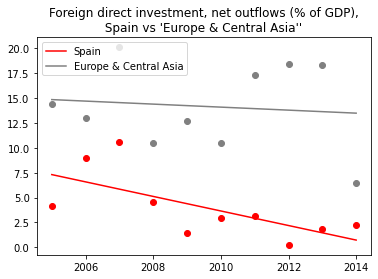

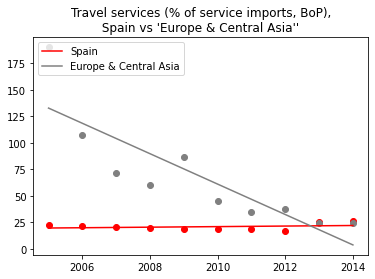

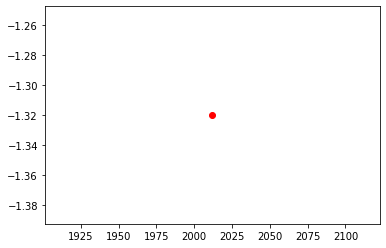

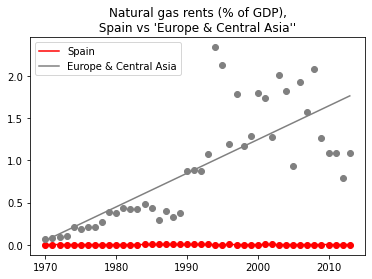

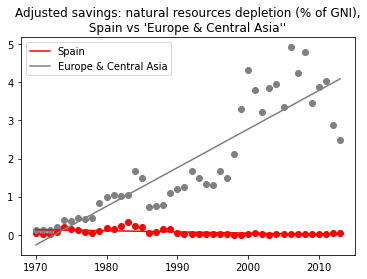

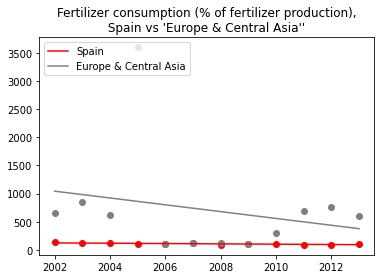

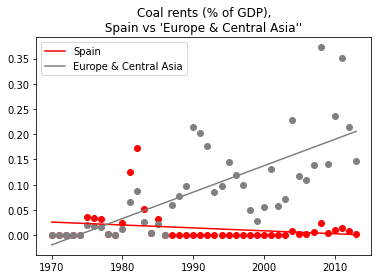

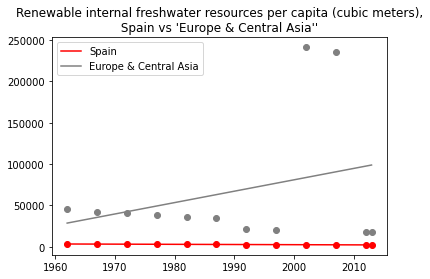

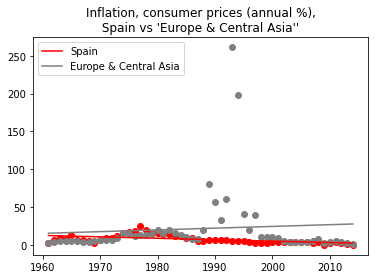

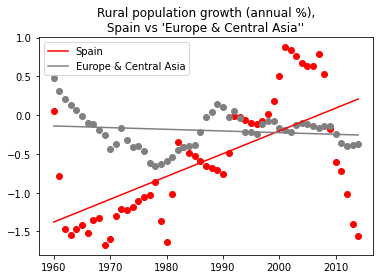

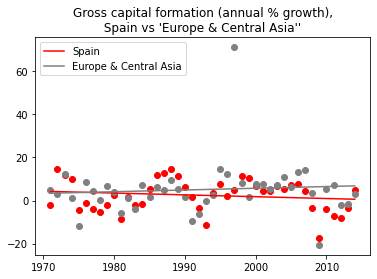

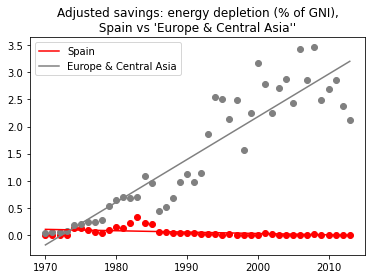

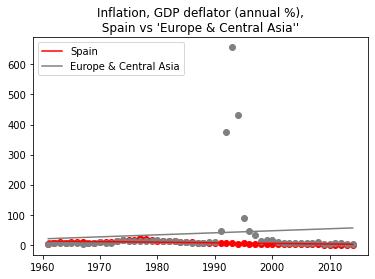

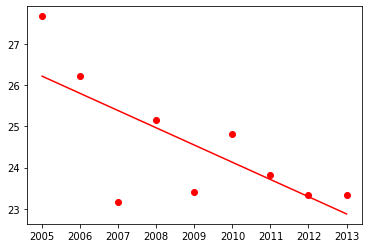

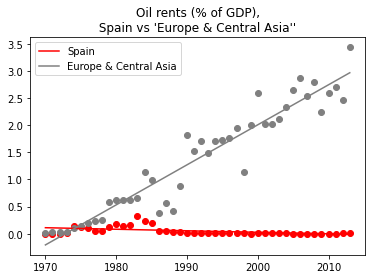

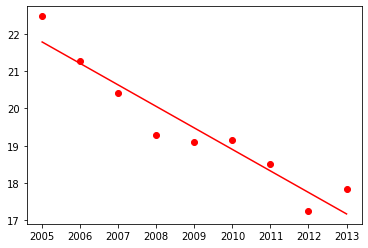

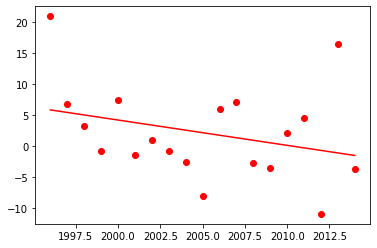

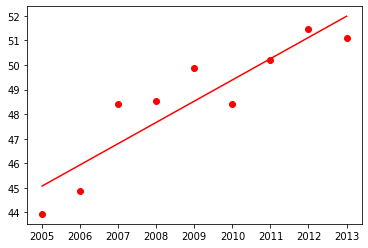

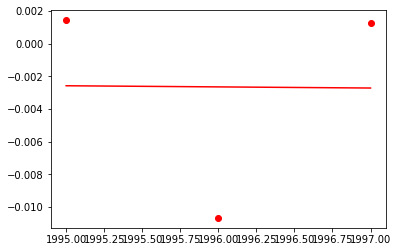

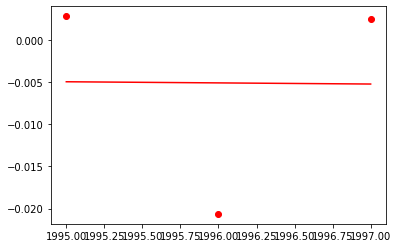

In [9]:
for IndicatorName in df_cosine_results.tail(20).IndicatorName.values :
    try:
        plt ,df_country,df_rest = Draw_Difference_Region(IndicatorName,CountryCode,Region)
    except :
        pass

In [10]:
 df_cosine_results.head(20)

,Cosine distance country-region,IndicatorName,Last Value in country,average Value in region,distance with average,CountryCode,Region,countries in the region
75,0.000040,"Youth literacy rate, population 15-24 years, both sexes (%)",99.669258,99.280955,0.000015,ESP,Europe & Central Asia,57
201,0.000099,Access to electricity (% of population),100.000000,99.572972,0.000018,ESP,Europe & Central Asia,57
421,0.000271,Income share held by fourth 20%,23.450000,22.414477,0.002134,ESP,Europe & Central Asia,57
423,0.000461,"Gross enrolment ratio, primary, gender parity index (GPI)",1.009460,0.991537,0.000327,ESP,Europe & Central Asia,57
238,0.000620,"Adult literacy rate, population 15+ years, both sexes (%)",98.079124,97.011481,0.000121,ESP,Europe & Central Asia,57
192,0.000980,"Current education expenditure, primary (% of total expenditure in primary public institutions)",95.908958,92.549688,0.001317,ESP,Europe & Central Asia,57
184,0.001231,"Current education expenditure, secondary (% of total expenditure in secondary public institutions)",91.605614,92.424764,0.000079,ESP,Europe & Central Asia,57
117,0.001379,"Current education expenditure, total (% of total expenditure in public institutions)",92.155197,91.786435,0.000016,ESP,Europe & Central Asia,57
398,0.001391,"Gross enrolment ratio, primary and secondary, gender parity index (GPI)",1.007720,0.993185,0.000214,ESP,Europe & Central Asia,57
140,0.001440,Income share held by third 20%,17.030000,16.906247,0.000054,ESP,Europe & Central Asia,57


In [11]:
for IndicatorName in df_cosine_results.head(20).IndicatorName.values :
    try:
        plt ,df_country,df_rest = Draw_Difference(IndicatorName,CountryCode,CountryCompare)
    except :
        pass


In [12]:
df_indicators = pd.concat([df_rankings.head(20),df_cosine_results.head(20)])
df_indicators.sort_values(by=['distance with average'], ascending=False)

,ranking,order,IndicatorName,Last Value in country,average Value in region,distance with average,CountryCode,Region,countries in the region,Cosine distance country-region
0,1.0,top,"Listed domestic companies, total",3538.000000,335.466119,91.136036,ESP,Europe & Central Asia,57,NaN
0,1.0,top,Time required to start a business (days),138.000000,20.780268,31.819927,ESP,Europe & Central Asia,57,NaN
2,3.0,top,GEF benefits index for biodiversity (0 = no biodiversity potential to 100 = maximum),6.842703,1.700861,9.139028,ESP,Europe & Central Asia,57,NaN
2,3.0,top,"Point-of-sale terminals (per 100,000 adults)",3523.039000,1349.233603,2.595775,ESP,Europe & Central Asia,57,NaN
1,2.0,top,"Taxes on income, profits and capital gains (% of total taxes)",68.677883,33.503132,1.102278,ESP,Europe & Central Asia,57,NaN
837,2.0,bottom,Adjusted savings: net forest depletion (% of GNI),0.000000,0.085367,1.000000,ESP,Europe & Central Asia,57,NaN
123,2.0,bottom,Time spent dealing with the requirements of government regulations (% of senior management time),0.800000,8.116800,0.812592,ESP,Europe & Central Asia,57,NaN
118,5.0,bottom,Informal payments to public officials (% of firms),4.400000,30.930894,0.735731,ESP,Europe & Central Asia,57,NaN
910,1.0,bottom,Unemployment with secondary education (% of total unemployment),7.400000,49.480351,0.723258,ESP,Europe & Central Asia,57,NaN
651,1.0,bottom,Taxes on goods and services (% value added of industry and services),2.575314,13.903937,0.663863,ESP,Europe & Central Asia,57,NaN


# Get feature importance

In [20]:
indicators_to_improve = ['Time required to start a business (days)',
                       'Firms that do not report all sales for tax purposes (% of firms)',
                       'Unemployment, total (% of total labor force)',
                         'Vulnerable employment, total (% of total employment)'
                        ]



# Build model

In [21]:
def get_data(REGION,array_indicators):
    
    """Return dataframe, with the indicators specified in """
    conn = sqlite3.connect('../input/world-development-indicators/database.sqlite')
    array_dfs=[]

    MIN_YEAR=pd.read_sql(f""" SELECT Min(Year) FROM Indicators""",conn).values[0][0]

    array_countries=pd.read_sql(f"""SELECT CountryCode from Country WHERE Region = '{REGION}' """,conn).CountryCode.values

    for CountryCode in tqdm(array_countries):
        array_results = []
        array_years_with_data = pd.read_sql(f""" SELECT distinct(Year) FROM Indicators WHERE  CountryCode = '{CountryCode}'  """,conn).Year.values
        df_country_all_years = pd.read_sql(f"""
                        SELECT IndicatorName,Value,Year
                        FROM Indicators
                        WHERE 
                        CountryCode = '{CountryCode}' """,conn) 
        for Year in array_years_with_data:
            dict_country_year = { 'CountryCode' : CountryCode , "Year" : Year, "Decade" : round((Year - MIN_YEAR) / 10)}
            try :
                df = df_country_all_years.query(f"Year == {Year}")[["IndicatorName","Value"]]
                df = df.T
                df.columns=df.iloc[0]
                df = df.iloc[1:].rename_axis(None, axis=1)
                df = df.reset_index()
                dict_row = {k : v[0] for k,v in df.to_dict('dict').items()}
            except: continue
            array_results.append({**dict_country_year, **dict_row} )

        df_temp = pd.DataFrame(array_results)
        kk=pd.DataFrame()
        kk[["CountryCode" ,"Year", "Decade"]]=df_temp[["CountryCode" ,"Year", "Decade"]]
        for column in list(set(df_temp.columns)&set(array_indicators)) :
            df_temp[column].apply(pd.to_numeric,errors='coerce')
            kk[column]=df_temp[column].fillna(df_temp[column].mean())  
        array_dfs.append(kk)
    df=pd.concat(array_dfs)
    return df

#df = get_data(Region,ARRAY_INDICATORS)
#df

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb

def train_data_for(kk,X_column):
    def r2(rf, X_train, y_train):
        return r2_score(y_train, rf.predict(X_train))
    
    y = kk[X_column]
    X = kk[[ x  for x in  kk.columns  if x != X_column]]
    np.random.seed(seed = 42)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.8, random_state = 42)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
#Fit the regressor to the training set and make predictions on the test set using the familiar .fit() and .predict() methods.

    xg_reg.fit(X_train,y_train)

    preds = xg_reg.predict(X_test)

    rf = xg_reg  
    print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(
        rf.score(X_train, y_train),rf.score(X_valid, y_valid))) 
    
    perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)
    ax = perm_imp_rfpimp.head(10).plot(kind="barh")
    ax.set_title(X_column) 
    return ax,perm_imp_rfpimp

#ax,perm_imp_rfpimp = train_data_for(kk,X_column)
                 

In [23]:


def get_data(Region,array_indicators):
    
    """Return dataframe, with the indicators specified in """
    conn = sqlite3.connect('../input/world-development-indicators/database.sqlite')
    array_dfs=[]

    MIN_YEAR=pd.read_sql(f""" SELECT Min(Year) FROM Indicators""",conn).values[0][0]

    array_countries=pd.read_sql(f"""SELECT CountryCode from Country WHERE Region = '{Region}' """,conn).CountryCode.values

    all_values =  pd.read_sql(f"""SELECT IndicatorName,Year,Value,CountryCode
               FROM Indicators
               WHERE 
                    CountryCode in ( SELECT CountryCode  FROM Country WHERE Region = '{Region}' )  
               """,conn)
    print(all_values.shape)
    for CountryCode in tqdm(array_countries):
        array_results = []
        #print("1")
           
        #array_years_with_data = pd.read_sql(f""" SELECT distinct(Year) FROM Indicators WHERE  CountryCode = '{CountryCode}'  """,conn).Year.values
        df_country_all_years = all_values.copy().query(f"  CountryCode == '{CountryCode}'")
        #df_country_all_years = pd.read_sql(f"""
        #                SELECT IndicatorName,Value,Year
        #                FROM Indicators
        #                WHERE 
        #                CountryCode = '{CountryCode}' """,conn) 
        array_years_with_data = df_country_all_years.Year.unique().tolist()
        #print("2",array_years_with_data)

        for Year in tqdm(array_years_with_data):
            dict_country_year = { 'CountryCode' : CountryCode , "Year" : Year, "Decade" : round((Year - MIN_YEAR) / 10)}
            try :
                df = df_country_all_years.query(f"Year == {Year}")[["IndicatorName","Value"]]

                df = df.T
                df.columns=df.iloc[0]
                
                df = df.iloc[1:].rename_axis(None, axis=1)
                df = df.reset_index()
                #print("6")
                dict_row = {k : v[0] for k,v in df.to_dict('dict').items()}
            except: continue
            array_results.append({**dict_country_year, **dict_row} )

        df_temp = pd.DataFrame(array_results)
        kk=pd.DataFrame()
        kk[["CountryCode" ,"Year", "Decade"]]=df_temp[["CountryCode" ,"Year", "Decade"]]
        for column in list(set(df_temp.columns)&set(array_indicators)) :
            df_temp[column].apply(pd.to_numeric,errors='coerce')
            kk[column]=df_temp[column].fillna(df_temp[column].mean())  
        array_dfs.append(kk)
    df=pd.concat(array_dfs)
    return df

file="all_countries_years.csv"
try:
    df = pd.read_csv(file, index_col=0)
except FileNotFoundError: 
    df = get_data(Region,ARRAY_INDICATORS)
    df.to_csv(file)
    
df

,CountryCode,Year,Decade,Gross fixed capital formation (constant 2005 US$),GDP per capita (constant 2005 US$),General government final consumption expenditure (constant 2005 US$),"International tourism, number of departures","Survival rate to Grade 5 of primary education, both sexes (%)",Tax revenue (% of GDP),Adjusted savings: particulate emission damage (% of GNI),...,Population in urban agglomerations of more than 1 million (% of total population),"Listed domestic companies, total","Stocks traded, turnover ratio of domestic shares (%)","Net intake rate to Grade 1 of primary education, both sexes (%)",Market capitalization of listed domestic companies (% of GDP),Population in the largest city (% of urban population),Real effective exchange rate index (2010 = 100),Population in largest city,"Stocks traded, total value (% of GDP)",S&P Global Equity Indices (annual % change)
0,ALB,1960,0.0,2.600500e+09,2237.927086,8.866854e+08,2.372800e+06,96.542601,13.679192,1.445173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ALB,1961,0.0,2.600500e+09,2237.927086,8.866854e+08,2.372800e+06,96.542601,13.679192,1.445173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ALB,1962,0.0,2.600500e+09,2237.927086,8.866854e+08,2.372800e+06,96.542601,13.679192,1.445173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALB,1963,0.0,2.600500e+09,2237.927086,8.866854e+08,2.372800e+06,96.542601,13.679192,1.445173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,1964,0.0,2.600500e+09,2237.927086,8.866854e+08,2.372800e+06,96.542601,13.679192,1.445173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,UZB,2011,5.0,6.478568e+09,796.350418,2.518122e+09,6.431429e+05,NaN,NaN,1.234117,...,7.556208,132.000000,61.103086,75.766876,1.01988,20.889082,NaN,2.216946e+06,0.182279,NaN
52,UZB,2012,5.0,7.230082e+09,849.059692,2.518122e+09,6.431429e+05,NaN,NaN,1.234117,...,7.473133,98.166667,61.103086,75.766876,1.01988,20.654283,NaN,2.225088e+06,0.209045,NaN
53,UZB,2013,5.0,7.938630e+09,902.773319,2.518122e+09,6.431429e+05,NaN,NaN,1.234117,...,7.384334,98.166667,61.103086,75.766876,1.01988,20.389138,NaN,2.233259e+06,0.209045,NaN
54,UZB,2014,5.0,8.700739e+09,959.573606,2.518122e+09,6.431429e+05,NaN,NaN,1.234117,...,7.291082,98.166667,61.103086,75.766876,1.01988,20.097807,NaN,2.241461e+06,0.209045,NaN


In [24]:
def get_data_for_training(X_column):
    kk  = pd.read_csv("first_model.csv")
    kk
    for column in ARRAY_INDICATORS :
        try :
            kk[column]=kk[column].fillna(kk[column].mean())
        except:
            pass
    kk.columns=[ x  for x in  kk.columns  if x != X_column] + [ X_column]

    kk= kk[kk.reset_index().columns[4:]]
    #for column in kk.columns:
    #    kk[column]=((kk[column]-kk[column].min())/(kk[column].max()-kk[column].min()))
    return kk

R^2 Training Score: 0.93 
R^2 Validation Score: 0.82
R^2 Training Score: 0.93 
R^2 Validation Score: 0.82
R^2 Training Score: 0.93 
R^2 Validation Score: 0.82
R^2 Training Score: 0.93 
R^2 Validation Score: 0.82



,Importance,Target indicator,Feature
Feature,,,
Time required to build a warehouse (days),0.080205,Time required to start a business (days),Time required to build a warehouse (days)
"Transport services (% of service exports, BoP)",0.051125,Time required to start a business (days),"Transport services (% of service exports, BoP)"
Food imports (% of merchandise imports),0.030970,Time required to start a business (days),Food imports (% of merchandise imports)
"Out-of-school children of primary school age, both sexes (number)",0.026449,Time required to start a business (days),"Out-of-school children of primary school age, both sexes (number)"
"Bound rate, simple mean, manufactured products (%)",0.022953,Time required to start a business (days),"Bound rate, simple mean, manufactured products (%)"
"Unemployment, total (% of total labor force)",0.021020,Time required to start a business (days),"Unemployment, total (% of total labor force)"
Import value index (2000 = 100),0.017818,Time required to start a business (days),Import value index (2000 = 100)
"Tariff rate, applied, simple mean, manufactured products (%)",0.017739,Time required to start a business (days),"Tariff rate, applied, simple mean, manufactured products (%)"
"Tariff rate, most favored nation, simple mean, primary products (%)",0.017142,Time required to start a business (days),"Tariff rate, most favored nation, simple mean, primary products (%)"


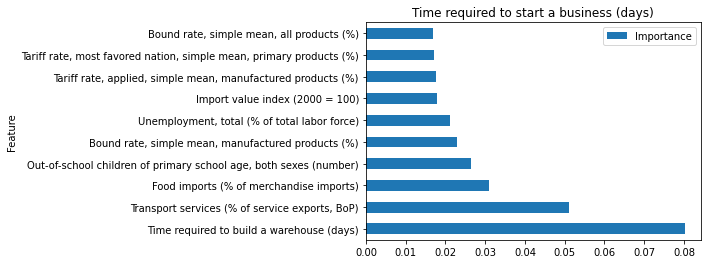

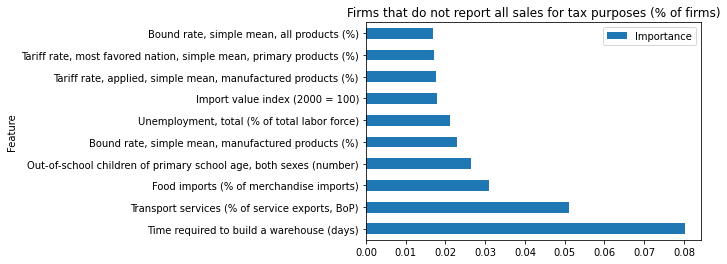

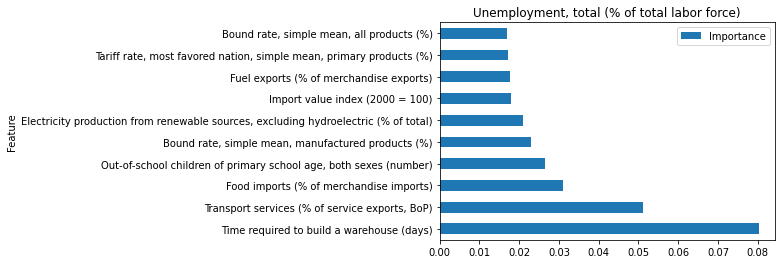

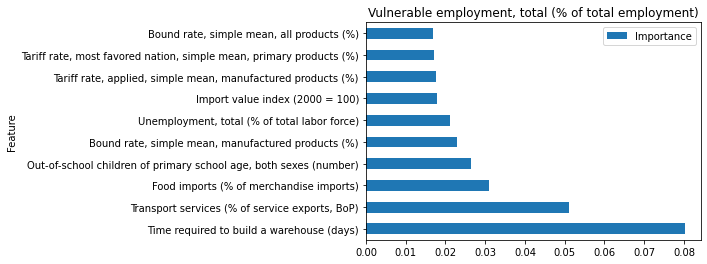

In [25]:
secondary_features = []
for indicator_to_improve in tqdm(indicators_to_improve) :
    try :
        kk                 = get_data_for_training(indicator_to_improve)                                                       
        ax,perm_imp_rfpimp = train_data_for(kk,indicator_to_improve)
        perm_imp_rfpimp = perm_imp_rfpimp.head(10)
        perm_imp_rfpimp['Target indicator'] = indicator_to_improve
        perm_imp_rfpimp['Feature'] = perm_imp_rfpimp.index
        secondary_features.append(perm_imp_rfpimp)
    except: continue
df = pd.concat(secondary_features)
df

In [26]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout

def sankey(margin_top=10, **value):
    """Show SankeyWidget with default values for size and margins"""
    layout = Layout(width="1024", height="800")

    return SankeyWidget(layout=layout,
                        margins=dict(top=margin_top, bottom=0, left=500, right=200),
                        **value)


In [58]:
df = pd.concat(secondary_features)

links = df
links['source'] = links['Feature']
links['target'] = links['Target indicator']
links['value']  = links['Importance']
links['type'] = links['Feature']

Objectives = [x for x in df['Target indicator'].unique() ]
Indicators = [x for x in df['Feature'].unique() ]

groups = [
    {'id': 'Objectives', 'title': 'Objectives', 'nodes': Objectives },
    {'id': 'Indicators', 'title': 'Indicators', 'nodes': Indicators }
]

#sankey(links=links)
links=links[['source','target','value','type']]
links=links.reset_index()
links=links.to_dict(orient = 'records')
sankey(links=links, groups=groups)

SankeyWidget(groups=[{'id': 'Objectives', 'title': 'Objectives', 'nodes': ['Time required to start a business …

In [28]:
secondary_features[0].index

Index(['Time required to build a warehouse (days)', 'Transport services (% of service exports, BoP)', 'Food imports (% of merchandise imports)', 'Out-of-school children of primary school age, both sexes (number)', 'Bound rate, simple mean, manufactured products (%)', 'Unemployment, total (% of total labor force)', 'Import value index (2000 = 100)', 'Tariff rate, applied, simple mean, manufactured products (%)', 'Tariff rate, most favored nation, simple mean, primary products (%)', 'Bound rate, simple mean, all products (%)'], dtype='object', name='Feature')

In [ ]:
links = df.copy()


In [32]:
from IPython.display import (
    Image,
    SVG
)
sankey(links=links).auto_save_svg('test.svg')


SankeyWidget(layout=Layout(height='800', width='1024'), links=[{'Feature': 'Time required to build a warehouse…

In [52]:
array

['Time required to start a business (days)',
 'Firms that do not report all sales for tax purposes (% of firms)',
 'Unemployment, total (% of total labor force)',
 'Vulnerable employment, total (% of total employment)']